In [188]:
import json
import csv
import re
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from operator import itemgetter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Using some stopwords from https://github.com/AlludedCrabb/sound-tasty
cooking_stop_words = list(set([
        'canned', 'cans', 'drained', 'and', 'halved', 'cup', 'cups',
        'teaspoon', 'tablespoon', 'teaspoons', 'tablespoons',
        'finely', 'freshly', 'fresh', 'thickcut', 'to', 'taste',
        'grated', 'cut', 'into', 'wedges', 'pounds', 'unpeeled', 'large',
        'minced', 'slice', 'slices', 'sliced', 'thick-cut', 'cut',
        'crosswise', 'pieces', 'toothpicks', 'low-fat', 'chopped', 'or',
        'taste', 'cooked', 'dry', 'shredded', 'beaten', 'dried', 'melted',
        'stems', 'removed', 'diced', 'ounce', 'ounces', 'packages',
        'softened', 'such', 'RedHot®', 'RedHot', 'Franks', "Frank's",
        'crumbled', 'Old', 'Bay®', 'Bay', 'pinch', 'for', 'garnish', 'slice',
        'slices', 'needed', 'inch', 'cubes', 'cooking', 'spray', 'ground',
        'rotisserie', 'lowfat', 'as', 'quarteres', 'cloves', 'more', 'can',
        'package', 'frozen', 'thawed', 'packet', 'reducedfat', 'Knorr',
        'container', 'pound', 'peeled', 'deveined', 'seeded', 'ripe',
        'English', 'juiced', 'plus', 'more', 'Hass', 'cubed', 'Mexicanstyle',
        'hearts', 'prepared', 'party', 'pitted', 'mashed',
        'roma', 'optional', 'chunk', 'Hot', 'bunch', 'cleaned', 'box',
        'chickenflavored', 'Golden', 'delicious', 'cored', 'any', 'flavor',
        'flavored', 'whole', 'allpurpose', 'all', 'purpose', 'deep', 'frying',
        'dash', 'packed', 'in', 'French', 'jar', 'small', 'head', 'little',
        'smokie', 'seasoned', 'Boston', 'Bibb', 'leaves', 'lean', 'pickled',
        'Asian', 'dark', 'flaked', 'rolled', 'packed', 'jellied',
        'thirds', 'with', 'attached', 'skewers', 'skinless', 'boneless',
        'half', 'kernels', 'rinsed', 'quart', 'quarts', 'kernel',
        'Italianstyle', 'unpopped', 'lightly', 'coating', 'SAUCE',
        'lengthwise', 'miniature', 'semisweet', 'rinsed', 'round',
        'squeezed', 'stewed', 'raw', 'the', 'liquid', 'reserved', 'medium',
        'instant', 'solid', 'pack', 'refrigerated', 'halves', 'distilled',
        'loaf', 'extra', 'virgin', 'crushed', 'kosher', 'toasted', 'buttery',
        'TM', 'panko', 'Japanese', 'regular', 'bottle', 'bottles', 'thin',
        'peel', 'paper', 'thick', 'circles', 'unbleached',
        'breast', 'breasts', 'wings', 'strips', 'jumbo', 'giant', 'chunks',
        'quickcooking', 'sweetened', 'flakes', 'Ranchstyle', 'snipped',
        'food', 'ROTEL', 'Italian', 'sticks', 'stick', 'crescent', 'thinly',
        'boiled', 'Genoa', 'roasted', 'thin', 'extrasharp', 'pressed',
        'sifted', 'split', 'tips', 'discarded', 'mini', 'deli', 'drain',
        'reserve', 'diameter', 'Greek', 'Thai', 'drops', 'square', 'crusty',
        'American', 'selfrising', 'imitation', 'Wings', 'apart', 'at',
        'joints', 'wing', 'tips', 'discarded', 'parts',
        'tops', 'seperated', 'blend', 'coarsely', 'sweet', 'stalk', 'heads',
        'husked', 'divided', 'pats', 'unsalted', 'active', 'warm', 'sea',
        'separated', 'herb', 'overripe', 'degrees', 'F', 'C', 'room',
        'temperature', 'machine', 'very', 'pint', 'puree', 'coarse',
        'envelopes', 'lukewarm', 'creamstyle', 'unsweetened',
        'lite', 'of', 'chilled', 'freezer', 'cold', 'brushing', 'nonfat',
        'squares', 'tails', 'thigh', 'quarters', 'Masterpiece', 'KC', 'from',
        'El', 'Paso', 'bulk', 'Hunts', 'Roma', 'light', 'fluid', 'lagerstyle',
        'stalks', 'quartered', 'undrained', 'drained', 'Tony', 'Chacheres',
        'lump', 'uncooked', 'cube', 'bits', 'hair', 'angel', 'trimmed',
        'stew', 'spaghetti', 'brisket', 'bitesized', 'matchstick', 'Chobani',
        'unbaked', 'crust', 'torn', 'bonein', 'pounded', 'bitesize',
        'granules', 'boiling', 'yolk', 'coloring', 'pinch', 'a', 'blender',
        'fine', 'which', 'extralarge', 'use', 'will', 'make', 'garnish',
        'barely', 'moistened', 'about', 'right', 'before', 'serving', 'mix', 
        'thinly-sliced', 'thinly-sliced', 'etc', 'excess', 'granulated', 'peeled', 
        'extra-virgin', 'pinch'
        ]))

unhelpful = list(set(['fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 
             'mild', 'hot', 'minced', 'dark roast', 'unsifted', 'canned', 
             'cans', 'drained', 'halved', 'finely', 'freshly', 'thickcut', 
             'grated', 'cut', 'unpeeled', 'large', 'minced', 'slice', 
             'slices', 'sliced', 'chopped','shredded', 'beaten', 'dried', 
             'melted', 'stems', 'softened', 'packages', 'crumbled', 'ground',
             'low-fat', 'rotisserie', 'lowfat', 'can', 'thawed', 'packet', 
             'reducedfat', 'small', 'pats', 'regular', 'lukewarm', 'mashed', 
             'stalk', 'breast', 'breasts', 'juiced', 'halves', 'extrasharp', 
             'sharp', 'extra sharp', 'frozen', 'raw', 'warm', 'divided', 
             'little', 'squares', 'thinly', 'thick', 'rinsed', 'toasted', 
             'bitesize', 'chunks', 'refrigerated', 'kernel', 'kernels', 
             'jar', 'lengthwise', 'unpeeled', 'cleaned', 'paper', 'melted', 
             'separated', 'seperated', 'deveined', 'party', 'bunch', 'overripe', 
             'boiled', 'chunk', 'container', 'bitesized', 'sweet', 'strips', 
             'sifted', 'roma', 'very', 'undrained', 'stewed', 'thawed', 'lean', 
             'roasted', 'extra', 'lite', 'coarsely', 'pressed', 'square', 
             'jumbo', 'yolk', 'yolks', 'barely', 'pitted', 'cored', 'puree', 
             'cubes', 'angel', 'hair', 'angelhair', 'giant', 'husked', 'chilled', 
             'thigh', 'trimmed', 'thin', 'lightly', 'cubed', 'drops', 'grated', 
             'boneless', 'unsalted', 'pieces', 'skinless', 'pounded', 
             'chickenflavored', 'extralarge', 'medium', 'reserve', 'unbaked', 
             'crushed', 'wings', 'crosswise', 'cold', 'bonein', 'bone in', 
             'squeezed', 'kosher', 'miniature', 'tails', 'quarters', 'attached', 
             'loaf', 'dry', 'more', 'head', 'removed', 'packed', 'hearts', 
             'matchstick', 'unbleached', 'heads', 'stems', 'sea', 'diced', 
             'mini', 'cut', 'unpopped', 'box', 'uncooked', 'freezer', 'stalks', 
             'shredded', 'halved', 'snipped', 'thick-cut', 'split', 'seeded', 
             'sweetened', 'discarded', 'lump', 'boiling', 'whole', 'semisweet', 
             'semi-sweet', 'quartered', 'moistened', 'reserved', 'prepared', 
             'fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 'mild', 
             'hot', 'minced', 'dark roast', 'unsifted', 'quaker', 'raw', 'frozen', 
             'calore-wise', 'ziploc bag', 'real', 'lite', 'crisp', 'decaffeinated', 
             'canned', 'processed', 'cooked', 'unpeeled', 'also', 'store-bought', 
             'accepted', 'accommodate', 'accompaniment', 'accompaniments', 
             'according', 'across', 'acting', 'active', 'add', 'added', 'additional',
             'additive', 'adds', 'adjoining', 'adjustable', 'adjusting', 'aged',
             'ahead', 'aisle', 'aka', 'almost', 'along', 'alternatively', 'aluminum', 
             'amazon', 'amount', 'amounts', 'angle', 'angled', 'animal', 'another', 
             'apart', 'appetizer', 'appropriate', 'approx', 'approximately', 'area', 
             'aroma', 'aromatic', 'around', 'aside', 'ask', 'assembling', 'assorted',
             'attachment', 'attachments', 'authentic', 'available', 'avoid', 'away',
             'bag', 'bags', 'baked', 'baker', 'bakery', 'bakeware', 'ball', 'balls',
             'bands', 'based', 'basket', 'baskets', 'baster', 'basting', 'bearded',
             'beards', 'beating', 'becomes', 'bench', 'best', 'better', 'big', 'bit',
             'bite', 'bits', 'blade', 'blend', 'blended', 'blender', 'blotted', 'body',
             'boil', 'boning', 'bottom', 'bottomed', 'bottoms', 'bought', 'bowl', 'bowls',
             'boxes', 'braised', 'braising','branch','branches','brand','brands','brewed',
             'briefly','bright','broil','broiled','broken','brought','brush','brushed',
             'brushes','brushing','bulk','burn','burner','burning','buy','call','called',
             'calorie','canal','canner','canning','canvas','capacity','carbon','cardboard',
             'cards','careful','carefully','carton','case','casing','casings','cast',
             'catalogue','cavity','centimeter','ceramic','changes','charcoal','charlotte',
             'charred','cheap','chef','chewy','chiffonade','choice','chopping','chopstick',
             'chopsticks','cl','clarified','clark','classic','clean','clear','cleaver','click',
             'cloth','club','cm','coarser','coat','coated','coating','coiled','coils','coin','coins',
             'colander','coleman','collapsible','colman','color','colored','com','combination',
             'combine','combined','come','comes','commercial','commercially','commonly','company',
             'completely','con','condiment','condiments','connective','consistency','containers',
             'containing','contains','content','converted','cook','cooker','copper','core','cores',
             'corkscrew','count','counter','couple','course','court','cracks','craft','credit',
             'crisply','crock','cross','crosscut','cultivated','cupmirin','cupsfresh','cupspanko',
             'cupstomato','cupsturkey','cure','cured','curing','curled','curly','cutinto','damaged',
             'damp','dampened','damson','dark','dash','dashes','de','debearded','deboned','decorate',
             'decorating','decoration','decorations','decorative','deep','defatted','defrosted','del',
             'dense','depending','desert','desiccated','desired','dessert','dessicated','diagonal',
             'diagonally','diameter','diamond','dice','diet','different','difficult','digital',
             'diluted','dim','dinner','dipper','dipping','directions','discard','discarding',
             'discolored','dish','dishes','disk','disks','disposable','dissolved','distilled',
             'domestic','done','doone','double','dover','dowel','dozen','drain','draining',
             'dredging','drink','drips','drizzle','drizzling','drop','dust','dusting','duty',
             'dyed','easier','east','easter','eastern','easy','edge','edged','edges','edible',
             'edward','eight','eighteen','eighth','eighths','either','el','electric','elixir',
             'em','empty','en','enameled','end','ends','english','enough','epi','equipment',
             'equivalent','etc','ethnic','european','even','ever','exceed','excellence',
             'excellent','excess','excluding','exotic','expose','exposed','extremely','eyed',
             'fairly','family','famous','fan','fancy','farm','farmed','farmer','farmers',
             'farms','fashioned','fast','faster','favorite','feathers','fed','feet','fermented',
             'fiery','filled','filling','fillings','filter','filtered','find','fine','finishing',
             'fire','firm','firmly','first','fishmonger','fit','fitted','fitting','five','fl',
             'flameproof','flattened','flavor','flavored','flavorful','flavoring','flavors',
             'flexible','floral','fluid','flying','foam','foamy','foil','following','follows',
             'food','foods','forced','form','formed','forming','forms','found','four','fourths',
             'fragments','fragrant','free','freeze','freshepazote','freshest','freshwater','fried',
             'fries','frosting','full','fully','fun','ga','gallon','gallons','garnish','garnishes',
             'garnishing','gas','gem','generous','generously','gently','girl','give','gives','glass',
             'glasses','glitter','globe','glove','gloves','go','goes','good','gourmet','grade',
             'grain','grained','grains','grainy','gram','grams','granulated','grate','grater',
             'grating','gratings','greased','greasing','great','griddle','grill','grilled',
             'grilling','grind','grinder','grinding','grindings','grinds','groceries','grocery',
             'gummy','gutted','ha','half','hammer','hand','handful','handfuls','handheld','handle',
             'handles','handling','hands','hard','headnote','health','heaped','heaping','hearty',
             'heat','heated','heatproof','heavily','heavy','hellmann','herb','herbed','herbes',
                      'herbs','high','hinged','hispanic','hold','hole','holes','holiday','holland',
                      'hollow','hollowed','holy','home','homemade','hon','honeyed','hook','hoop',
                      'horizontally','hour','hours','house','hulled','icing','id','igourmet',
                      'imitation','imported','inch','inches','include','included','including',
                      'increase','india','indian','individual','indonesian','info','ingredient',
                      'ingredients','inner','insert','inside','insist','insta','instacure','instant',
                      'instead','instructions','intact','interior','intervals','inverted','irish',
                      'iron','island','israeli','italian','jarred','jars','jell','john','joint',
                      'joints','juice','juices','juicy','keep','keeping','kept','kettle','key',
                      'kg','kha','kikkoman','kilogram','kind','king','kirby','kitchen','kneading',
                      'knife','knob','knot','known','knuckle','kum','la','label','labeled','ladle',
                      'larger','last','late','latin','latino','latter','laver','layer','layers',
                      'leafed','leafy','least','leathery','leave','leaved','leaving','lebanese',
                      'left','leftover','length','lengths','less','let','level','leveled','leveling',
                      'lexington','lid','lids','like','lined','liner','liners','lining','link','links',
                      'lip','liquefy','liquid','list','liter','liters','litres','live','lo','local',
                      'log','logs','long','loofah','look','loose','loosely','loosen','lot','lots',
                      'low','lower','machine','made','mae','mail','major','make','maker','makes',
                      'making','maldon','malted','mam','manischewitz','manual','many','marbled',
                      'marked','market','markets','mash','mason','master','mat','may','maytag',
                      'measure','measured','measuring','meaty','medallions','mediterranean','melt','melting','members','metal','method','mexican','mexicana','mexico','mg','micro','microplane','middle','milder','mildly','mill','milled','milliliter','milliliters','minces','minus','minute','minutes','mission','mitts','mix','mixed','mixer','mixing','mixture','ml','mm','moderately','moist','moistening','moisture','mold','molds','moon','moons','mortar','mountain','mrs','mt','much','mullet','multi','multigrain','nationwide','native','natural','naturally','near','necessary','need','needed','needle','needlenose','needles','nests','neutral','nine','non','nonreactive','nonstick','nontoxic','north','northern','notes','number','nutritional','oblong','offset','often','old','ole','omit','omitting','one','ones','online','oounces','open','opened','opening','opposite','optional','order','ordered','organic','oriental','original','ounceahi','outer','outside','oven','ovenproof','overnight','pack','package','packaged','packets','pad','page','paintbrush','pair','pan','pans','papery','parboiled','parchment','pareve','paring','park','part','partially','parts','parve','passed','passing','passion','passover','pasteurized','pat','patted','pattern','patties','peasant','peeled','peeler','peeling','pencil','people','peppered','pepperidge','per','percent','perfect','perfectly','perforated','perilla','pernod','persian','person','pesticide','pestle','petals','petit','petite','petits','philadelphia','pi','pick','picked','pickle','pickled','pickling','picks','picnic','piece','pierced','pin','pinch','pinches','pint','pints','piping','pit','pits','pkg','place','places','plain','plane','plant','plastic','plate','plates','platter','platters','pleated','plenty','plump','plumped','plunged','plus','poached','poaching','pocket','pocketless','pockets','pod','pods','point','points','polish','polished','pollen','pop','popped','portion','portions','portuguese','possible','pot','pounder','pour','poured','powder','powdered','powdery','power','pre','prebaked','precooked','prefer','preferable','preferably','preferred','preheat','premade','premium','preparation','prepare','preserved','preserves','presliced','press','pressure','pretty','prevent','prickly','prime','prince','problem','procedure','process','processor','produce','product','products','pt','pulled','pullman','pulp','pulsed','pulverized','purchase','purchased','pure','purpose','qt','qts','quality','quart','quarter','quarts','quatre','quick','quill','quills','rack','racks','raised','ram','ramekin','ramekins','range','rapid','rashers','rather','razor','read','ready','really','recipe','recipelink','recipes','recommend','recommended','reconstituted','rectangle','rectangles','rectangular','reduce','reduced','referred','refried','refrigerator','reheated','release','remainder','remaining','remains','removable','remove','rendered','request','resealable','resembles','rest','restaurant','results','retain','rib','ribbon','ribbons','ricer','rich','rick','rim','rimmed','rinse','ripened','river','roast','roasting','roasts','robust','rock','roll','rolled','rolling','rolls','room','rough','roughly','round','rounded','rounds','royal','rub','rubbed','rubber','rubbing','ruler','runny','rustic','rustique','sack','safe','safety','saucepan','save','sawdust','sawed','scalded','scale','scaled','scales','scant','scharffen','scissors','scoop','scooped','scooping','scoops','scored','scout','scrambled','scraped','scraper','scraps','screw','scrubbed','sealable','sealing','seasonal','seasonally','seasoned','seasoning','seasonings','second','seconds','section','sectioned','sections','securely','sediment','segment','segmented','segments','self','semi','semicircles','semidried','semisoft','separate','separately','separator','serve','serving','set','seven','several','shape','shaped','shapes','shaping','shards','shaved','shaving','shavings','shears','sheet','sheets','shipping','shop','shopping','shops','shortcut','shred','shreds','shucked','side','sides','sieve','sift','sifter','sifting','silpat','silver','similar','simmer','simmering','simple','simply','single','six','sixteen','sixths','size','sized','sizes','skewer','skewers','skillet','skillets','skim','skin','skinned','skins','skirt','slather','sleeve','slender','slicer','slicing','slightly','slim','slit','slivered','slivers','slotted','slow','slowly','smaller','smashed','snack','snacks','snapped','snow','soak','soaked','soaking','soft','soften','softer','softly','sold','solid','solids','something','sometimes','somewhat','sorted','sources','spare','sparkling','spatula','spatulas','spear','spears','special','specialty','spiced','spices','spicy','spider','spiked','splash','sponge','spongy','spoon','spooned','spoons','spots','spotted','spray','sprig','sprigs','spring','springform','springs','squeeze','st','stacked','stainless','stale','stand','standing','starchy','starter','states','steamer','steaming','steel','steen','stem','stemmed','step','sticky','stiff','stiffly','still','stir','stirred','stirring','stone','stop','storage','store','storebought','stores','stovetop','strained','strainer','strands','straw','streaky','streaming','street','strength','string','stringed','strings','strip','striped','stripped','strong','stronger','stuck','stuffed','stuffing','sturdy','style','sub','submerged','substitute','substituted','substitutes','sum','super','superfine','superior','supermarket','supermarkets','superpremium','supply','sure','surface','swanson','sweep','sweetener','sweetness','table','tablepoons','tablet','tall','tart','taste','tasting','tbsp','tear','teardrop','teaspoonfenugreek','teaspooon','tel','temperature','ten','tender','tends','tepid','terra','terrine','terry','test','tester','texture','textured','thai','thaw','thermometer','thickest','thickly','thickness','think','thinned','thinning','third','thirds','thirty','thoroughly','thousand','thread','threads','three','tie','tied','tight','tightly','time','times','tin','tins','tiny','tip','tissue','toaster','toasting','together','ton','tongs','toothpicks','toothpicks','top','topping','toppings','tops','torch','torn','toss','tossed','tossing','total','tough','towel','towels','traditional','tradizionale','trans','transfer','transparent','tray','treated','tree','tri','triangles','triangular','trimmings','triple','tropical','true','trumpet','try','tub','tube','tubes','tubular','turning','tweezers','twelve','twenty','twice','twine','two','tying','type','ultra','ultrapasteurized','unavailable','unblanched','uncle','unconverted','uncured','uncut','underripe','unfiltered','unflavored','unglazed','ungreased','unhulled','unhusked','uniform','uniformly','united','unless','unpitted','unrefined','unrinsed','unripe','unrolled','unscented','unseasoned','unshelled','unskinned','unsliced','unsmoked','unsprayed','unsulfured','unsweetened','unthawed','untoasted','untreated','untrimmed','unwaxed','unwrapped','upper','use','used','using','usually','uwajimaya','vacuum','valrhona','varieties','variety','various','vary','version','vertically','video','visible','vitamin','warmed','wash','washed','watch','watercolor','watery','waxed','waxy','way','wear','weave','weighed','weighing','weight','weighting','weights','well','west','westphalian','wet','whatever','wheel','whip','whipped','whipping','whisk','whisked','wide','width','wild','william','wilted','wilton','wineglass','winter','wipe','wiped','wire','without','wok','wood','wooden','woody','work','works','would','wrapped','wrappers','wrapping','www'
'year', 'yield',
'zester'
    
]))

brands = ['rotel', 'absolut', 'betty crocker', 'jello', 'diana', 'ener-g', 
          'del-monte', "hunt's", 'martha', 'goya', 'cracker barrel', 
          'hamburger helper', "mccormick's", 'pepperidge farm', 'knorr', 
          'godiva', 'hidden valley', 'tabasco', 'branston', "kellogg's", 
          'hodgson mill', 'kraft', 'johnsonville', 'jim beam', 'mccormick', 
          'equal', 'jell-o', 'jimmy dean', 'country bob', "smucker's", 
          'toblerone', 'gerber', 'nestle', 'nestl', 'malt-o-meal', 'triscuit', 
          'ragu', 'campbell', 'hormel', 'earth balance', 'pillsbury', 
          "bird's eye", "campbell's", "betty crocker's", 'gold medal', 
          'crystal light', 'milnot', "land o' lakes", 'herb-ox', 'quaker',
          'coffee-mate', 'contadina', 'j&d', 'fantastic foods', 'bacardi', 
          'eckrich', 'little smokies', 'snickers', 'ortega', 'bayou blast', 
          "annie's", 'mrs. dash', 'mori-nu', 'old el paso', 'original supreme',
          'morton', 'nabisco', 'rice-a-roni', 'stolichnaya', "lawry's", 
          'st. germain', "eggland's best", 'club house "lagrille"', 'hostess',
          'giada de laurentiis genovese', '*available in most target stores', 
          'jarlsberg', 'pillsbury plus', 'ro-tel', 'pillsbury grands', 
          'shilling', 'hershey', 'hershey carb alternatives', 'pasta roni', 
          'pastaroni', 'torani', 'v8', 'v8 fusion', 'ghiradelli', 'oscar mayer',
          "bird's", 'smithfield', 'cadbury', 'sun-maid', 'karo', 
          'wishbone deluxe', 'vochelle', 'laughing cow', 'omega', 'stirrings',
          'duncan hines', 'barilla', 'carnation', 'bertolli', 'bertolli®',
          'breyers®', "1/2", "14.5", "''", "'s", "best®", "bell®", "bragg", 
          "crystal®", "crock®", "foods®", "frank's®", "gold®", "hellmann's®",
          "johnsonville®", "knorr®", "lipton®", "n't", "n", "pillsbury™", 
          "progresso™", "progresso", "ranch®", "secrets®", "valley®", "vay®",
          "yoplait®", "®", "’", 'boboli', 'bobolis', 'classico'
         ]

measures = ['cup', 'cups', 'pound', 'pounds', 'teaspoon', 'tsp', 'teaspoons', 
            'tablespoon', 'tablespoons', 'tbs', 'ounce', 'ounces', 'oz', 'see', 
            'note', 'lb', 'lbs', '¼', '½', '⅓', '⅔']


stopwords_list = stopwords.words('english') + list(string.punctuation) + unhelpful\
                 + brands + measures
lemmatizer = WordNetLemmatizer()

In [3]:
def cuisine_namer(text):
    if text == 'Central American/Caribbean':
        return 'Caribbean'
    elif text == 'Jewish':
        return 'Kosher'
    elif text == 'Eastern European/Russian':
        return 'Eastern Europe'
    elif text in ['Spanish/Portuguese', 'Greek']:
        return 'Mediterranean'
    elif text == 'Central/South American':
        return 'Latin American'
    elif text == 'Sushi':
        return 'Japanese'
    elif text == 'Southern Italian':
        return 'Italian'
    elif text in ['Southern', 'Tex-Mex']:
        return 'American'
    elif text in ['Southeast Asian', 'Korean']:
        return 'Asian'
    else:
        return text

In [4]:
filename = "../raw_data/recipes-en-201706/epicurious-recipes_m2.json"
with open(filename, 'r') as f:
    datastore = json.load(f)

In [5]:
datastore_df = pd.DataFrame(datastore)

In [6]:
datastore_df.head()

,id,dek,hed,pubDate,author,type,url,photoData,tag,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,dateCrawled
0,54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,2014-08-19T04:00:00.000Z,[],recipe,/recipes/food/views/pickle-brined-fried-chicke...,"{'id': '54a2b64a6529d92b2c003409', 'filename':...","{'category': 'ingredient', 'name': 'Chicken', ...",3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,1498547035
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,2008-09-09T04:00:00.000Z,[{'name': 'Edda Servi Machlin'}],recipe,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...",3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,1498547740
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,2008-09-10T04:00:00.000Z,[{'name': 'Marcy Goldman'}],recipe,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,1498547738
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,2008-09-08T04:00:00.000Z,[{'name': 'Faye Levy'}],recipe,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,1498547740
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2008-09-09T04:00:00.000Z,[{'name': 'Joan Nathan'}],recipe,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,1498547740


In [7]:
X_train, X_test= train_test_split(datastore_df,
                                                    test_size=0.1,
                                                    random_state=10)

In [8]:
datastore_df_reduced = X_train.drop(['pubDate', 
                   'author', 
                   'type', 
                   'aggregateRating', 
                   'reviewsCount', 
                   'willMakeAgainPct', 
                   'dateCrawled'], 
                  axis=1)

In [9]:
df_flattened = pd.concat([datastore_df_reduced.drop(['tag'], axis=1), 
           datastore_df_reduced['tag'].apply(pd.Series)], axis=1)

In [10]:
df_flattened_cleaned = df_flattened.drop([0,
                                          'photosBadgeAltText',
                                          'photosBadgeFileName',
                                          'photosBadgeID', 
                                          'photosBadgeRelatedUri'], axis=1)

In [11]:
df_flattened_cleaned

,id,dek,hed,url,photoData,ingredients,prepSteps,category,name,url
16343,54a438226529d92b2c01925e,This dip is our version of a Catalan sauce tha...,Romesco Sauce,/recipes/food/views/romesco-sauce-232504,"{'id': '560de5a3f3a00aeb2f1d549c', 'filename':...","[1 large tomato (1/2 lb), cored, 1 (1/2-oz) dr...",[Put oven rack in middle position and preheat ...,cuisine,Spanish/Portuguese,
5317,54a423a56529d92b2c009d4a,"Sausage-wrapped ""Scotch"" eggs are a tasty and ...",Smoked Scotch Eggs,/recipes/food/views/smoked-scotch-eggs-395691,"{'id': '54b17785c6a78d1a4a60ca49', 'filename':...","[6 large eggs, Ice water, 1 pound ground pork,...",[Put the eggs in a medium saucepan and cover w...,ingredient,Egg,
5591,54a4242019925f464b379f9e,"Small, sweet wild Maine shrimp are sold frozen...",Shrimp and Cucumber Salad with Horseradish Mayo,/recipes/food/views/shrimp-and-cucumber-salad-...,"{'id': '54b0b585c6a78d1a4a60affc', 'filename':...","[1 cup mayonnaise, 1/4 cup (or more) prepared ...","[Whisk mayonnaise, 1/4 cup horseradish, and vi...",type,Salad,
5980,54a424d419925f464b37a7dc,Aromatic caraway seeds lend a delicate nutty f...,Caraway Chicken Breasts with Sweet-and-Sour Re...,/recipes/food/views/caraway-chicken-breasts-wi...,"{'id': '54b338f821388ef838b06ef7', 'filename':...","[1 teaspoon caraway seeds, 1/2 teaspoon (scant...",[Sprinkle caraway and 1/4 teaspoon allspice on...,ingredient,Chicken,
5409,54a423d46529d92b2c009f28,A salad this simple requires the finest ingred...,"Tomato Salad with Shallot Vinaigrette, Capers,...",/recipes/food/views/tomato-salad-with-shallot-...,"{'id': '54b178b41cc76a014cfb03c7', 'filename':...","[3 tablespoons minced shallots, 3 tablespoons ...","[Combine shallots, vinegar, 1/2 teaspoon salt,...",type,Salad,
...,...,...,...,...,...,...,...,...,...,...
10201,54a42cb019925f464b38076f,The mild flavor of mahimahi is a perfect match...,Grilled Mahimahi with Tamarind Glaze,/recipes/food/views/grilled-mahimahi-with-tama...,"{'id': '560dd75df3a00aeb2f1d276e', 'filename':...","[1/2 cup tamarind pulp (from a pliable block),...",[Soak tamarind pulp in boiling-hot water in a ...,cuisine,American,
9372,54a42b306529d92b2c00fa8a,Start steaming some rice right after you prehe...,Grilled Halibut with Coriander-Pepita Butter,/recipes/food/views/grilled-halibut-with-coria...,"{'id': '5674617eb47c050a284a4e11', 'filename':...",[1/4 cup salted shelled pumpkin seeds (pepitas...,[Prepare barbecue (medium-high heat). Place pu...,special-consideration,Quick & Easy,
28017,54a469ba6529d92b2c027ace,Strawberries and whipped cream are sandwiched ...,Strawberry Stacks,/recipes/food/views/strawberry-stacks-445,"{'id': '56746183b47c050a284a4e15', 'filename':...","[1 cup all purpose flour, 6 tablespoons sugar,...","[Mix flour, 2 tablespoons sugar, orange peel a...",ingredient,Liqueur,
29199,54a46f5e19925f464b398aaa,Can be prepared in 45 minutes or less.,Cappuccino Sundaes,/recipes/food/views/cappuccino-sundaes-1990,"{'id': '5674617eb47c050a284a4e11', 'filename':...","[1/2 cup strong brewed coffee, 1/2 cup whippin...","[Combine coffee, cream, sugar and cinnamon in ...",ingredient,Coffee,


In [12]:
cols = ['id', 'description', 'title', 'url', 'photo_data', 'ingredients', 'steps', 'category', 'name', 'remove']
df_flattened_cleaned.columns = cols
df_flattened_cleaned.columns

Index(['id', 'description', 'title', 'url', 'photo_data', 'ingredients',
       'steps', 'category', 'name', 'remove'],
      dtype='object')

In [13]:
df_flat_cln = df_flattened_cleaned.drop('remove', axis=1)

In [14]:
train_nans = df_flat_cln[df_flat_cln['category'] == 'cuisine']

In [15]:
train_nans = train_nans[train_nans['ingredients'].isna()]

In [16]:
labeled_cuisine_df = df_flat_cln[df_flat_cln['category'] == 'cuisine']
labeled_cuisine_df.dropna(axis=0, inplace=True)

//anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
labeled_cuisine_df.shape

(13335, 9)

In [18]:
all_cuisines = list(labeled_cuisine_df['name'].values)

In [19]:
all_cuisines

['Spanish/Portuguese',
 'Italian',
 'American',
 'American',
 'American',
 'Mexican',
 'American',
 'American',
 'Italian',
 'Irish',
 'Chinese',
 'American',
 'American',
 'French',
 'American',
 'Indian',
 'Middle Eastern',
 'American',
 'Spanish/Portuguese',
 'American',
 'Italian',
 'French',
 'Mexican',
 'Italian',
 'Italian',
 'Italian',
 'Mexican',
 'American',
 'Indian',
 'Jewish',
 'African',
 'American',
 'English',
 'American',
 'French',
 'Italian',
 'Mexican',
 'Asian',
 'American',
 'Greek',
 'American',
 'Italian',
 'Indian',
 'Southwestern',
 'Cajun/Creole',
 'Central/South American',
 'Moroccan',
 'French',
 'French',
 'English',
 'Cajun/Creole',
 'Jewish',
 'Greek',
 'Vietnamese',
 'Italian',
 'Italian',
 'Eastern European/Russian',
 'English',
 'Mexican',
 'Eastern European/Russian',
 'American',
 'Italian',
 'American',
 'American',
 'Middle Eastern',
 'French',
 'Irish',
 'American',
 'English',
 'English',
 'Southwestern',
 'French',
 'American',
 'Mexican',
 'Ame

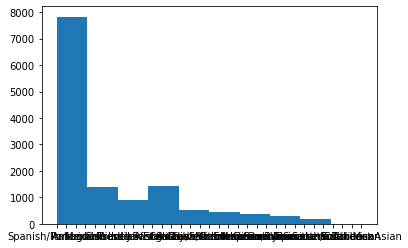

In [20]:
plt.hist(all_cuisines);

In [21]:
pd.Series(all_cuisines).value_counts()

American                      4926
Italian                       1892
French                        1173
Asian                         1125
Mexican                        726
Indian                         327
Jewish                         319
Mediterranean                  292
Spanish/Portuguese             284
Middle Eastern                 264
Greek                          247
English                        204
Central American/Caribbean     180
Eastern European/Russian       156
Southwestern                   130
Cajun/Creole                   126
Central/South American         126
Scandinavian                   117
Thai                           110
Irish                          110
Chinese                        105
Moroccan                       102
African                         83
Japanese                        79
German                          66
Vietnamese                      56
Korean                           3
Tex-Mex                          2
Southern            

In [22]:
sum(pd.Series(all_cuisines).value_counts())

13335

In [23]:
pd.Series(all_cuisines).value_counts() / sum(pd.Series(all_cuisines).value_counts())

American                      0.369404
Italian                       0.141882
French                        0.087964
Asian                         0.084364
Mexican                       0.054443
Indian                        0.024522
Jewish                        0.023922
Mediterranean                 0.021897
Spanish/Portuguese            0.021297
Middle Eastern                0.019798
Greek                         0.018523
English                       0.015298
Central American/Caribbean    0.013498
Eastern European/Russian      0.011699
Southwestern                  0.009749
Cajun/Creole                  0.009449
Central/South American        0.009449
Scandinavian                  0.008774
Thai                          0.008249
Irish                         0.008249
Chinese                       0.007874
Moroccan                      0.007649
African                       0.006224
Japanese                      0.005924
German                        0.004949
Vietnamese               

In [24]:
labeled_cuisine_df['imputed_label'] = labeled_cuisine_df['name'].apply(cuisine_namer)

//anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
all_recipes_ingredients = labeled_cuisine_df['ingredients'].tolist()

In [26]:
all_recipes_ingredients

[['1 large tomato (1/2 lb), cored',
  '1 (1/2-oz) dried ancho chile*',
  '1/3 cup extra-virgin olive oil',
  '2 tablespoons hazelnuts, toasted and loose skins rubbed off with a kitchen towel while warm',
  '2 tablespoons blanched almonds',
  '1 (1/2-inch-thick) slice firm white bread, cut into 1/2-inch cubes',
  '2 large garlic cloves, sliced',
  '1/8 teaspoon dried hot red pepper flakes',
  '1/4 cup drained bottled pimientos, rinsed',
  '2 tablespoons water',
  '1 tablespoon red-wine vinegar',
  '1/4 teaspoon salt, or to taste'],
 ['2 3/4 cups all-purpose flour, plus extra for dusting',
  '3 eggs',
  '1 tablespoon olive oil',
  '1 pound 2 ounces potatoes, diced',
  '14 ounces Swiss chard, stalks removed',
  '3 tablespoons butter',
  '1 garlic clove, finely chopped',
  '1 sprig chopped fresh parsley',
  '1 leek, chopped',
  '7 ounces Italian sausage, skinned and chopped',
  '3/4 cups bread crumbs',
  'Generous 1 cup grated Parmesan cheese',
  '1 egg, lightly beaten',
  'Salt and pepper

In [27]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_list, 
                                                        min_df=2,
                                                        token_pattern=r'(?u)\b[a-zA-Z]{2,}\b', 
                                                        preprocessor=lemmatizer.lemmatize
                                                       )
tfidf.fit(labeled_cuisine_df['ingredients'].str.join(' ').str.lower())
response = tfidf.transform(labeled_cuisine_df['ingredients'].str.join(' ').str.lower())

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alternatives', 'annie', 'balance', 'band', 'barrel', 'bayou', 'beam', 'beard', 'bell', 'betty', 'bird', 'blast', 'bob', 'bone', 'breyers', 'calore', 'carb', 'card', 'change', 'coffee', 'coil', 'country', 'cow', 'crack', 'cracker', 'crocker', 'crystal', 'cube', 'dean', 'deluxe', 'direction', 'doe', 'drip', 'duncan', 'earth', 'eggland', 'ener', 'eye', 'fantastic', 'fat', 'feather', 'foot', 'fourth', 'fragment', 'frank', 'fry', 'fusion', 'genovese', 'germain', 'giada', 'gold', 'grands', 'hamburger', 'heart', 'helper', 'hidden', 'hines', 'hodgson', 'hunt', 'instruction', 'interval', 'jim', 'jimmy', 'kellogg', 'lagrille', 'lakes', 'land', 'laughing', 'laurentiis', 'lawry', 'le', 'lipton', 'litre', 'maid', 'malt', 'mate', 'mayer', 'meal', 'medal', 'medallion', 'member', 'mince', 'mi

In [28]:
nlpskl = pd.DataFrame(response.toarray(), 
                      columns=tfidf.get_feature_names(),
                      index=labeled_cuisine_df.index)
nlpskl

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,yuzu,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini
16343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
nlpskl.columns

Index(['aceto', 'achiote', 'acid', 'acini', 'acorn', 'adobo',
       'adrianascaravan', 'adzuki', 'african', 'agave',
       ...
       'yuzu', 'za', 'zabaglione', 'zealand', 'zest', 'zested', 'zinfandel',
       'zingermans', 'ziti', 'zucchini'],
      dtype='object', length=2045)

In [30]:
X_test

,id,dek,hed,pubDate,author,type,url,photoData,tag,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,dateCrawled
12590,54a430de19925f464b383ac3,"Brandi Neuwirth of Cary, North Carolina, write...",Watermelon-Mint Ice Cubes,2006-06-13T16:02:42.000Z,[{'name': 'Brandi Neuwirth'}],recipe,/recipes/food/views/watermelon-mint-ice-cubes-...,"{'id': '560dd76c7b55306961bfaa0b', 'filename':...","{'category': 'cuisine', 'name': 'American', 'u...",4.00,[6 cups 1-inch cubes seeded watermelon (about ...,[Puree watermelon in processor (there should b...,1,100,1498548022
32007,54a47d4b19925f464b39bff7,,Chicken Piccata,2004-08-20T12:48:48.000Z,[],recipe,/recipes/food/views/chicken-piccata-5154,"{'id': '578d20ad95824bf90525e55a', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...",3.33,"[4 skinless boneless chicken breast halves, 3 ...",[Place chicken between 2 large sheets of plast...,244,92,1498548435
27434,54a4671019925f464b396a4a,Can be prepared in 45 minutes or less.,"Roasted Red Pepper, Pepper Jack, and Pepperoni...",2004-08-20T12:48:48.000Z,[{'name': 'Kenneth Walther'}],recipe,/recipes/food/views/roasted-red-pepper-pepper-...,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'type', 'name': 'Sandwich', 'url'...",3.14,[1 round loaf sourdough bread (about 7 inches ...,"[Preheat oven to 375° F., Cut eight 1/2-inch-t...",7,100,1498548377
2233,54a4189d6529d92b2c006364,,Oriental Pudding,2004-08-20T04:00:00.000Z,[{'name': 'James Beard'}],recipe,/recipes/food/views/oriental-pudding-20049,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'cuisine', 'name': 'Asian', 'url'...",2.67,"[1 8-ounce package pitted dates, 1/2 cup sugar...",[Cut the dates into small pieces and combine t...,3,100,1498548860
15258,54a4353219925f464b3872d9,This dish is great alongside the Lemony Chicke...,Spicy Spinach Linguine with Olive Oil and Garlic,2007-01-04T04:25:28.000Z,[],recipe,/recipes/food/views/spicy-spinach-linguine-wit...,"{'id': '560d9943f9a84192308a1930', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...",3.47,"[12 ounces spinach linguine, 6 tablespoons ext...",[Cook linguine in large pot of boiling salted ...,29,89,1498547930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34193,581793b758b6c2cf3d999849,"For deep apple flavor, the fruit in this pie i...",Classic Apple Pie,2016-11-01T19:44:38.491Z,[{'name': 'Paula Haney'}],recipe,/recipes/food/views/classic-apple-pie,"{'id': '5818a37eee26df88234c36e0', 'filename':...","{'category': 'type', 'name': 'Pie', 'url': '',...",3.67,"[1/2 teaspoon all-purpose flour, 1/2 teaspoon ...","[In a small bowl, whisk together flour and sug...",3,67,1498546548
15695,54a435e66529d92b2c01841e,"Katy Hees of Santa Fe, New Mexico, writes: ""Ea...",Fried Eggs on Toast with Pepper Jack and Avocado,2006-02-01T04:00:00.000Z,[{'name': 'Katy Hees'}],recipe,/recipes/food/views/fried-eggs-on-toast-with-p...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","{'category': 'cuisine', 'name': 'American', 'u...",3.14,"[3 tablespoons butter, room temperature, divid...",[Preheat broiler. Melt 1 tablespoon butter in ...,5,100,1498551821
1867,54a415ef6529d92b2c005c45,,Buffalo Meat Loaf,2004-08-20T04:00:00.000Z,[],recipe,/recipes/food/views/buffalo-meat-loaf-103049,"{'id': '561025bb7b55306961bffe6b', 'filename':...","{'category': 'ingredient', 'name': 'Game', 'ur...",3.54,"[1 cup chopped onion, 2 celery ribs, cut into ...","[Preheat oven to 375°F., Cook onion, celery, c...",34,89,1498548853
29544,54a470fb19925f464b39911c,,Pumpkin-Seed Brittle,2004-08-20T04:00:00.000Z,[],recipe,/recipes/food/views/pumpkin-seed-brittle-15334,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'type', 'name': 'Candy', 'url': '...",1.89,"[1/3 cup sugar, 1/4 cup water, 1/2 cup toasted...",[In a heavy skillet combine the sugar and the ...,13,43,1498549053


In [31]:
test_df_reduced = X_test.drop(['pubDate', 
                   'author', 
                   'type', 
                   'aggregateRating', 
                   'reviewsCount', 
                   'willMakeAgainPct', 
                   'dateCrawled'], 
                  axis=1)

In [32]:
test_df_reduced

,id,dek,hed,url,photoData,tag,ingredients,prepSteps
12590,54a430de19925f464b383ac3,"Brandi Neuwirth of Cary, North Carolina, write...",Watermelon-Mint Ice Cubes,/recipes/food/views/watermelon-mint-ice-cubes-...,"{'id': '560dd76c7b55306961bfaa0b', 'filename':...","{'category': 'cuisine', 'name': 'American', 'u...",[6 cups 1-inch cubes seeded watermelon (about ...,[Puree watermelon in processor (there should b...
32007,54a47d4b19925f464b39bff7,,Chicken Piccata,/recipes/food/views/chicken-piccata-5154,"{'id': '578d20ad95824bf90525e55a', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...","[4 skinless boneless chicken breast halves, 3 ...",[Place chicken between 2 large sheets of plast...
27434,54a4671019925f464b396a4a,Can be prepared in 45 minutes or less.,"Roasted Red Pepper, Pepper Jack, and Pepperoni...",/recipes/food/views/roasted-red-pepper-pepper-...,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'type', 'name': 'Sandwich', 'url'...",[1 round loaf sourdough bread (about 7 inches ...,"[Preheat oven to 375° F., Cut eight 1/2-inch-t..."
2233,54a4189d6529d92b2c006364,,Oriental Pudding,/recipes/food/views/oriental-pudding-20049,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'cuisine', 'name': 'Asian', 'url'...","[1 8-ounce package pitted dates, 1/2 cup sugar...",[Cut the dates into small pieces and combine t...
15258,54a4353219925f464b3872d9,This dish is great alongside the Lemony Chicke...,Spicy Spinach Linguine with Olive Oil and Garlic,/recipes/food/views/spicy-spinach-linguine-wit...,"{'id': '560d9943f9a84192308a1930', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...","[12 ounces spinach linguine, 6 tablespoons ext...",[Cook linguine in large pot of boiling salted ...
...,...,...,...,...,...,...,...,...
34193,581793b758b6c2cf3d999849,"For deep apple flavor, the fruit in this pie i...",Classic Apple Pie,/recipes/food/views/classic-apple-pie,"{'id': '5818a37eee26df88234c36e0', 'filename':...","{'category': 'type', 'name': 'Pie', 'url': '',...","[1/2 teaspoon all-purpose flour, 1/2 teaspoon ...","[In a small bowl, whisk together flour and sug..."
15695,54a435e66529d92b2c01841e,"Katy Hees of Santa Fe, New Mexico, writes: ""Ea...",Fried Eggs on Toast with Pepper Jack and Avocado,/recipes/food/views/fried-eggs-on-toast-with-p...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","{'category': 'cuisine', 'name': 'American', 'u...","[3 tablespoons butter, room temperature, divid...",[Preheat broiler. Melt 1 tablespoon butter in ...
1867,54a415ef6529d92b2c005c45,,Buffalo Meat Loaf,/recipes/food/views/buffalo-meat-loaf-103049,"{'id': '561025bb7b55306961bffe6b', 'filename':...","{'category': 'ingredient', 'name': 'Game', 'ur...","[1 cup chopped onion, 2 celery ribs, cut into ...","[Preheat oven to 375°F., Cook onion, celery, c..."
29544,54a470fb19925f464b39911c,,Pumpkin-Seed Brittle,/recipes/food/views/pumpkin-seed-brittle-15334,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'type', 'name': 'Candy', 'url': '...","[1/3 cup sugar, 1/4 cup water, 1/2 cup toasted...",[In a heavy skillet combine the sugar and the ...


In [33]:
test_df_flattened = pd.concat([test_df_reduced.drop(['tag'], axis=1), 
           test_df_reduced['tag'].apply(pd.Series)], axis=1)

In [34]:
test_df_flattened_cleaned = test_df_flattened.drop([0,
                                          'photosBadgeAltText',
                                          'photosBadgeFileName',
                                          'photosBadgeID', 
                                          'photosBadgeRelatedUri'], axis=1)

In [35]:
test_df_flattened_cleaned.columns = cols

In [36]:
test_df_flat_cln = test_df_flattened_cleaned.drop('remove', axis=1)

In [37]:
test_labeled_cuisine_df = test_df_flat_cln[test_df_flat_cln['category'] == 'cuisine']

In [38]:
test_labeled_cuisine_df['imputed_label'] = test_labeled_cuisine_df['name'].apply(cuisine_namer)

//anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
test_nans = test_labeled_cuisine_df[test_labeled_cuisine_df['category'] == 'cuisine']

In [40]:
test_nans.columns[test_nans.isna().any()].tolist()

['ingredients']

In [41]:
test_nans = test_nans[test_nans['ingredients'].isna()]

In [42]:
test_nans

,id,description,title,url,photo_data,ingredients,steps,category,name,imputed_label
3285,54a41f416529d92b2c00777c,"The best tagliatelle made in Bologna, as by Or...",Tagliatelle (Flat Egg Noodles),/recipes/food/views/tagliatelle-em-flat-egg-no...,"{'id': '5674617e47d1a28026045e4f', 'filename':...",NaN,[Make pasta all'uovo . When the dough has rest...,cuisine,Italian,Italian
1570,54a413ec6529d92b2c00569e,The texture of this spicy Brazilian dish falls...,Brazilian Black Beans,/recipes/food/views/brazilian-black-beans-20146,"{'id': '5674617e47d1a28026045e4f', 'filename':...",NaN,"[Pick over and rinse:, 2 cups black beans, Dra...",cuisine,Central/South American,Latin American
16980,54a43ada19925f464b3897fa,La Merenda di Victor\nWhen my husband was a sc...,Victor's Parmesan and Olive Oil Crostino,/recipes/food/views/victors-parmesan-and-olive...,"{'id': '56746183b47c050a284a4e15', 'filename':...",NaN,"[Cut slices from very good, crusty white bread...",cuisine,Italian,Italian
20893,54a451de6529d92b2c01ef4d,,Chicken Vedova,/recipes/food/views/chicken-vedova-108148,"{'id': '5674617eb47c050a284a4e11', 'filename':...",NaN,"[In Udine the chicken were free-range, small a...",cuisine,Italian,Italian


In [43]:
test_labeled_cuisine_df.dropna(axis=0, inplace=True)

//anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
test_labeled_cuisine_df.shape

(1497, 10)

In [45]:
test_response = tfidf.transform(test_labeled_cuisine_df['ingredients'].str.join(' ').str.lower())

In [46]:
test_nlpskl = pd.DataFrame(test_response.toarray(), 
                      columns=tfidf.get_feature_names(), 
                           index=test_labeled_cuisine_df.index)
test_nlpskl

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,yuzu,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini
12590,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
32007,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2233,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
15258,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19843,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16704,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
21098,0.0,0.0,0.0,0.0,0.0,0.287208,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
30453,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
27358,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227471


In [47]:
test_nlpskl.iloc[0]

aceto         0.0
achiote       0.0
acid          0.0
acini         0.0
acorn         0.0
             ... 
zested        0.0
zinfandel     0.0
zingermans    0.0
ziti          0.0
zucchini      0.0
Name: 12590, Length: 2045, dtype: float64

In [48]:
res_cos_sim = cosine_similarity(nlpskl, np.array(test_nlpskl.iloc[0]).reshape(1,-1))

In [49]:
res_cos_sim

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.06344744],
       [0.03519017],
       [0.01850724]])

In [50]:
np.argmax(res_cos_sim)

12474

In [51]:
nlpskl.iloc[12474]

aceto         0.0
achiote       0.0
acid          0.0
acini         0.0
acorn         0.0
             ... 
zested        0.0
zinfandel     0.0
zingermans    0.0
ziti          0.0
zucchini      0.0
Name: 12045, Length: 2045, dtype: float64

In [52]:
labeled_cuisine_df.iloc[12474]

id                                        54a42fcd6529d92b2c013618
description                                                       
title                  Lemon Sorbetto with Watermelon and Anisette
url              /recipes/food/views/lemon-sorbetto-with-waterm...
photo_data       {'id': '56746183b47c050a284a4e15', 'filename':...
ingredients      [3 tablespoons anisette (anise liqueur), 1 tab...
steps            [Stir together anisette and sugar in a large b...
category                                                   cuisine
name                                                       Italian
imputed_label                                              Italian
Name: 12045, dtype: object

In [53]:
labeled_cuisine_df.iloc[12474]['url']

'/recipes/food/views/lemon-sorbetto-with-watermelon-and-anisette-243202'

In [54]:
test_labeled_cuisine_df.iloc[0]

id                                        54a430de19925f464b383ac3
description      Brandi Neuwirth of Cary, North Carolina, write...
title                                    Watermelon-Mint Ice Cubes
url              /recipes/food/views/watermelon-mint-ice-cubes-...
photo_data       {'id': '560dd76c7b55306961bfaa0b', 'filename':...
ingredients      [6 cups 1-inch cubes seeded watermelon (about ...
steps            [Puree watermelon in processor (there should b...
category                                                   cuisine
name                                                      American
imputed_label                                             American
Name: 12590, dtype: object

In [55]:
labeled_cuisine_df.iloc[12474]['ingredients']

['3 tablespoons anisette (anise liqueur)',
 '1 tablespoon sugar',
 '1 (2-pound) wedge chilled watermelon',
 '1 tablespoon chopped mint',
 '1 pint lemon sorbetto (sorbet) or Italian ice',
 'Equipment: a 1-inch melon-ball cutter',
 'Garnish: mint sprigs']

In [56]:
test_labeled_cuisine_df.iloc[0]['ingredients']

['6 cups 1-inch cubes seeded watermelon (about 1/4 large melon)',
 '4 tablespoons (about) sugar',
 'Fresh mint leaves']

In [57]:
test_labeled_cuisine_df.iloc[0]['url']

'/recipes/food/views/watermelon-mint-ice-cubes-235177'

In [58]:
nlpskl.loc[:, nlpskl.iloc[12474] > 0].iloc[12474]

anise         0.240798
anisette      0.393914
cutter        0.287965
ice           0.198147
lemon         0.124659
liqueur       0.247460
melon         0.332069
mint          0.380730
sorbet        0.340600
sugar         0.096239
watermelon    0.316326
wedge         0.327610
Name: 12045, dtype: float64

In [59]:
test_labeled_cuisine_df.iloc[0]['imputed_label']

'American'

In [60]:
combo=pd.concat([nlpskl, labeled_cuisine_df['imputed_label']], axis=1)
combo

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini,imputed_label
16343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mediterranean
11650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Italian
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
9853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
23180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,English
2102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Italian
31210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,German
17904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American


In [61]:
lab_enc = LabelBinarizer()

In [62]:
training_labels = lab_enc.fit_transform(combo['imputed_label'])

In [63]:
lab_enc.classes_

array(['African', 'American', 'Asian', 'Cajun/Creole', 'Caribbean',
       'Chinese', 'Eastern Europe', 'English', 'French', 'German',
       'Indian', 'Irish', 'Italian', 'Japanese', 'Kosher',
       'Latin American', 'Mediterranean', 'Mexican', 'Middle Eastern',
       'Moroccan', 'Scandinavian', 'Southwestern', 'Thai', 'Vietnamese'],
      dtype='<U14')

In [64]:
len(lab_enc.classes_)

24

In [128]:
(training_labels)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [130]:
label_index = [np.argmax(label) for label in training_labels]
label_index

[16,
 12,
 1,
 1,
 1,
 17,
 1,
 1,
 12,
 11,
 5,
 1,
 1,
 8,
 1,
 10,
 18,
 1,
 16,
 1,
 12,
 8,
 17,
 12,
 12,
 12,
 17,
 1,
 10,
 14,
 0,
 1,
 7,
 1,
 8,
 12,
 17,
 2,
 1,
 16,
 1,
 12,
 10,
 21,
 3,
 15,
 19,
 8,
 8,
 7,
 3,
 14,
 16,
 23,
 12,
 12,
 6,
 7,
 17,
 6,
 1,
 12,
 1,
 1,
 18,
 8,
 11,
 1,
 7,
 7,
 21,
 8,
 1,
 17,
 1,
 1,
 1,
 1,
 11,
 12,
 1,
 1,
 1,
 12,
 17,
 1,
 1,
 18,
 1,
 1,
 2,
 1,
 12,
 8,
 1,
 16,
 8,
 1,
 11,
 1,
 8,
 8,
 1,
 2,
 1,
 8,
 12,
 12,
 1,
 11,
 2,
 1,
 16,
 2,
 17,
 1,
 1,
 2,
 2,
 14,
 19,
 2,
 1,
 12,
 6,
 1,
 12,
 2,
 7,
 12,
 1,
 16,
 8,
 2,
 1,
 1,
 17,
 1,
 18,
 1,
 2,
 1,
 10,
 11,
 14,
 1,
 8,
 1,
 1,
 17,
 16,
 1,
 2,
 1,
 1,
 8,
 1,
 2,
 12,
 18,
 1,
 2,
 12,
 1,
 7,
 17,
 1,
 2,
 17,
 21,
 1,
 18,
 1,
 6,
 14,
 17,
 2,
 12,
 2,
 1,
 1,
 16,
 1,
 1,
 1,
 1,
 16,
 2,
 1,
 10,
 1,
 1,
 1,
 17,
 9,
 1,
 2,
 1,
 9,
 1,
 1,
 16,
 12,
 16,
 1,
 18,
 1,
 17,
 12,
 14,
 1,
 12,
 0,
 1,
 2,
 2,
 12,
 19,
 1,
 2,
 2,
 20,
 1,
 16,
 2,
 1,
 1,
 16,


In [131]:
len(label_index)

13335

In [65]:
sm = SMOTE(random_state=42)

In [66]:
labeled_cuisine_df['imputed_label'].value_counts()

American          4929
Italian           1893
French            1173
Asian             1129
Mediterranean      823
Mexican            726
Indian             327
Kosher             319
Middle Eastern     264
English            204
Caribbean          180
Eastern Europe     156
Southwestern       130
Latin American     127
Cajun/Creole       126
Scandinavian       117
Thai               110
Irish              110
Chinese            105
Moroccan           102
African             83
Japanese            80
German              66
Vietnamese          56
Name: imputed_label, dtype: int64

In [67]:
X_res, y_res = sm.fit_resample(combo.drop(['imputed_label'], axis=1), training_labels)

In [82]:
tsvd1 = TruncatedSVD(n_components=50, random_state=20)

In [83]:
tsvd1.fit(combo.drop(['imputed_label'], axis=1))

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=20,
             tol=0.0)

In [84]:
tsvd1_ingreds = tsvd1.transform(combo.drop(['imputed_label'], axis=1))
tsvd1_ingreds.shape

(13335, 50)

In [85]:
tsne1 = TSNE(n_components=3)

In [86]:
tsne1.fit(tsvd1_ingreds)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=3, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)

In [91]:
tsne1_ingreds = tsne1.fit_transform(tsvd1_ingreds)

In [96]:
tsne1_ingreds.shape

(13335, 3)

In [98]:
tsne1_ingreds[:,0].shape

(13335,)

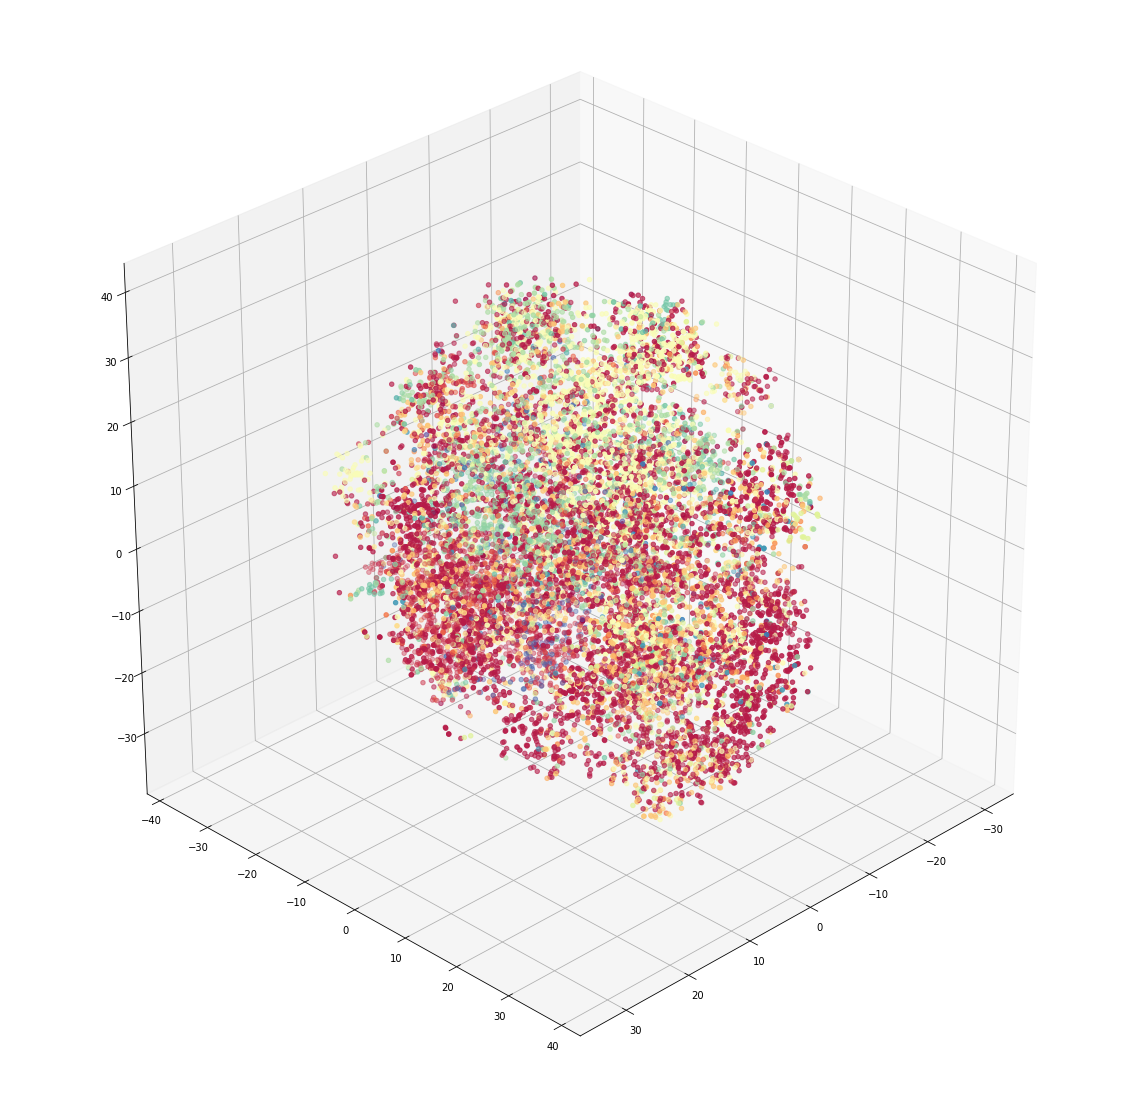

In [145]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne1_ingreds[:,0], ys=tsne1_ingreds[:,1], zs=tsne1_ingreds[:,2],
           c=label_index,
           cmap='Spectral')
ax.view_init(30, 45)
plt.show()

In [68]:
to_nn = combo.drop(['imputed_label'], axis=1)

In [70]:
X_res.shape

(118296, 2045)

In [75]:
X_res

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
y_res.shape

(118296, 24)

In [76]:
y_res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [146]:
embedding_size = 100
epochs_desired = 20
learning_rate = 0.025
regularization = 0.01
vocabulary_size = len(tfidf.get_feature_names())
algo_optimizer = 'adam'

In [73]:
model = keras.Sequential([
                        keras.layers.Embedding(input_dim=vocabulary_size, 
                                               output_dim=embedding_size,
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(200, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(150, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(100, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [74]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [80]:
model.fit(X_res, y_res, epochs=epochs_desired)

Train on 118296 samples
Epoch 1/50
118296/118296 [==============================] - 2081s 18ms/sample - loss: 3.1834 - accuracy: 0.0419
Epoch 2/50
118296/118296 [==============================] - 1863s 16ms/sample - loss: 3.1837 - accuracy: 0.0413
Epoch 3/50
118296/118296 [==============================] - 1851s 16ms/sample - loss: 3.1834 - accuracy: 0.0423
Epoch 4/50
118296/118296 [==============================] - 1852s 16ms/sample - loss: 3.1835 - accuracy: 0.0409
Epoch 5/50
118296/118296 [==============================] - 1854s 16ms/sample - loss: 3.1833 - accuracy: 0.0418
Epoch 6/50
118296/118296 [==============================] - 1858s 16ms/sample - loss: 3.1833 - accuracy: 0.0412
Epoch 7/50
118296/118296 [==============================] - 1855s 16ms/sample - loss: 3.1834 - accuracy: 0.0418
Epoch 8/50
118296/118296 [==============================] - 1852s 16ms/sample - loss: 3.1835 - accuracy: 0.0411
Epoch 9/50
118296/118296 [==============================] - 1847s 16ms/sample - 

KeyboardInterrupt: 

In [88]:
X_res2, y_res2 = sm.fit_resample(tsvd1_ingreds, training_labels)

In [174]:
tsvd1_ingreds.shape[1]

50

In [175]:
model2 = keras.Sequential([
                        keras.layers.Embedding(input_dim=tsvd1_ingreds.shape[1], 
                                               output_dim=30,
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [176]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [177]:
model2.fit(X_res2, y_res2, epochs=epochs_desired)

Train on 118296 samples
Epoch 1/20
118296/118296 [==============================] - 54s 460us/sample - loss: 3.1833 - accuracy: 0.0418
Epoch 2/20
 69408/118296 [================>.............] - ETA: 24s - loss: 3.1835 - accuracy: 0.0413

KeyboardInterrupt: 

In [147]:
tsvd2 = TruncatedSVD(n_components=30, random_state=20)

In [148]:
tsvd2.fit(combo.drop(['imputed_label'], axis=1))
tsvd2_ingreds = tsvd2.transform(combo.drop(['imputed_label'], axis=1))

In [180]:
tsvd2_ingreds.shape[1]

30

In [185]:
model3 = keras.Sequential([
                        keras.layers.Embedding(input_dim=tsvd2_ingreds.shape[1], 
                                               output_dim=tsvd2_ingreds.shape[1],
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [186]:
model3.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [183]:
X_res2a, y_res2a = sm.fit_resample(tsvd2_ingreds, training_labels)

In [187]:
model3.fit(X_res2a, y_res2a, epochs=epochs_desired, shuffle=True)

Train on 118296 samples
Epoch 1/20
118296/118296 [==============================] - 70s 592us/sample - loss: 3.1834 - accuracy: 0.0413
Epoch 2/20
118296/118296 [==============================] - 68s 571us/sample - loss: 3.1832 - accuracy: 0.0427
Epoch 3/20
118296/118296 [==============================] - 70s 594us/sample - loss: 3.1836 - accuracy: 0.0410
Epoch 4/20
118296/118296 [==============================] - 70s 591us/sample - loss: 3.1835 - accuracy: 0.0420
Epoch 5/20
118296/118296 [==============================] - 68s 575us/sample - loss: 3.1833 - accuracy: 0.0414
Epoch 6/20
118296/118296 [==============================] - 64s 545us/sample - loss: 3.1835 - accuracy: 0.0412
Epoch 7/20
118296/118296 [==============================] - 63s 532us/sample - loss: 3.1834 - accuracy: 0.0413
Epoch 8/20
118296/118296 [==============================] - 71s 598us/sample - loss: 3.1836 - accuracy: 0.0407
Epoch 9/20
118296/118296 [==============================] - 73s 619us/sample - loss: 3.1

In [161]:
y_res2a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [162]:
y_res2a * lab_enc.classes_

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> dtype('<U21')

In [178]:
lab_enc.classes_[2]

'Asian'

In [166]:
smoted_labels = [lab_enc.classes_[np.argmax(recipe)] for recipe in y_res2a]

In [171]:
pd.Series(smoted_labels).value_counts()

American          4929
Moroccan          4929
Asian             4929
Vietnamese        4929
Caribbean         4929
French            4929
Cajun/Creole      4929
Middle Eastern    4929
Mediterranean     4929
Southwestern      4929
Japanese          4929
Kosher            4929
Mexican           4929
Thai              4929
German            4929
Chinese           4929
Latin American    4929
Eastern Europe    4929
Scandinavian      4929
Italian           4929
English           4929
Indian            4929
Irish             4929
African           4929
dtype: int64

In [155]:
test3=model3.predict(X_res2a)

In [157]:
test3.shape

(118296, 24)

In [159]:
[test3[0] == row for row in test3]

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  

In [156]:
np.argmax(test3)

2

In [222]:
dtc = DecisionTreeClassifier(max_depth=30,random_state=20)

In [205]:
combo

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini,imputed_label
16343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mediterranean
11650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Italian
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
9853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
23180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,English
2102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Italian
31210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,German
17904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American


In [206]:
X_res4, y_res4 = sm.fit_resample(combo.drop(['imputed_label'], axis=1), combo['imputed_label'])   

In [223]:
dtc = dtc.fit(X_res4, y_res4)

In [224]:
y_res4_pred = dtc.predict(X_res4)

In [225]:
print("Accuracy:",sklearn.metrics.accuracy_score(y_res4, y_res4_pred))

Accuracy: 0.825556231825252


In [226]:
print(sklearn.metrics.confusion_matrix(y_res4, y_res4_pred))

[[4489   82    2    0    0    0    0   34  179    0    0    0   80    0
     0    0   49    2   12    0    0    0    0    0]
 [   0 2107   68    0    6    4   37  212 1504   15    4   16  309    0
    24   16  403  145   40    1    9    3    0    6]
 [   0  333 4071    0    2   31    2   14  206    0    5    0   17   19
     9    0   26  116    6    0    0    1    5   66]
 [   0  101   19 4413    0    0    0   35  345    0    0    0    7    0
     0    0    9    0    0    0    0    0    0    0]
 [   0  110   59    0 4151    0    1  125  232    2    1    0   13    0
     0    2   50  179    4    0    0    0    0    0]
 [   0   23   69    0    0 4763    0    4   50    0    0    0   10    0
     2    0    0    0    8    0    0    0    0    0]
 [   0  210    0    0    0    0 3551  264  734   25    0    3    6    0
    12    0  116    8    0    0    0    0    0    0]
 [   0  255    0    0    0    0    0 3829  667   10    0    0   40    0
     0    0  113    0   14    0    1    0    0    0]


In [227]:
print(sklearn.metrics.classification_report(y_res4, y_res4_pred))

                precision    recall  f1-score   support

       African       1.00      0.91      0.95      4929
      American       0.33      0.43      0.37      4929
         Asian       0.87      0.83      0.85      4929
  Cajun/Creole       1.00      0.90      0.94      4929
     Caribbean       1.00      0.84      0.91      4929
       Chinese       0.99      0.97      0.98      4929
Eastern Europe       0.96      0.72      0.82      4929
       English       0.75      0.78      0.77      4929
        French       0.30      0.75      0.43      4929
        German       0.96      0.95      0.95      4929
        Indian       0.99      0.84      0.91      4929
         Irish       0.99      0.83      0.90      4929
       Italian       0.65      0.58      0.61      4929
      Japanese       1.00      0.96      0.98      4929
        Kosher       0.97      0.82      0.89      4929
Latin American       0.97      0.79      0.87      4929
 Mediterranean       0.60      0.67      0.63  

In [200]:
test_labeled_cuisine_df['imputed_label']

12590     American
32007      Italian
2233         Asian
15258      Italian
19843     American
           ...    
16704    Caribbean
21098     American
30453     American
27358       French
15695     American
Name: imputed_label, Length: 1497, dtype: object

In [211]:
test_nlpskl

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,yuzu,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini
12590,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
32007,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2233,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
15258,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
19843,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16704,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
21098,0.0,0.0,0.0,0.0,0.0,0.287208,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
30453,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
27358,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227471


In [228]:
test_pred = dtc.predict(test_nlpskl)

In [229]:
print("Accuracy:",sklearn.metrics.accuracy_score(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))
print(sklearn.metrics.confusion_matrix(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))
print(sklearn.metrics.classification_report(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))

Accuracy: 0.3754175016700067
[[  0   1   0   0   0   0   0   0   0   0   0   0   1   0   1   0   1   0
    2   3   0   0   0   0]
 [  0 179  14   6   4   0   4  25 170   4   9   3  33   0   4   1  53  33
    6   1   4   2   0   0]
 [  1  10  83   0   0   8   0   2   6   0   1   1   2   5   0   0   2   6
    1   0   0   0   8   5]
 [  0   7   1   3   0   0   0   0   5   0   0   0   1   0   0   0   1   0
    0   0   0   0   0   0]
 [  0   1   0   0   3   0   0   0   1   0   0   0   0   0   1   0   1   1
    0   0   0   1   0   0]
 [  0   2   6   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   3   0   0   0   0   2   0   2   0   0   0   1   0   2   0   1   0
    0   0   0   0   0   0]
 [  0   6   1   0   0   0   1   3   7   0   0   1   0   0   1   0   1   0
    0   0   0   0   0   0]
 [  0  19   0   0   0   0   1   3  68   0   0   3   6   1   4   0  14   0
    0   1   0   0   0   0]
 [  0   4   0   0   0   0   0   1   4   2   0   0   0   0   0 

In [237]:
dtc2 = DecisionTreeClassifier(max_depth=200,random_state=20)
X_res5 = combo.drop(['imputed_label'], axis=1)
y_res5 = combo['imputed_label']
dtc2 = dtc2.fit(X_res5, y_res5)
y_res5_pred = dtc.predict(X_res5)
print("Accuracy:",sklearn.metrics.accuracy_score(y_res5, y_res5_pred))
print(sklearn.metrics.confusion_matrix(y_res5, y_res5_pred))
print(sklearn.metrics.classification_report(y_res5, y_res5_pred))

Accuracy: 0.5544056992875891
[[  56    6    1    0    0    0    0    1    7    0    0    0    2    0
     0    0    9    0    1    0    0    0    0    0]
 [   0 2107   68    0    6    4   37  212 1504   15    4   16  309    0
    24   16  403  145   40    1    9    3    0    6]
 [   0  113  862    0    1   11    1    3   47    0    3    0   10    5
     3    0   13   36    1    0    0    1    1   18]
 [   0   16    3   85    0    0    0    0   20    0    0    0    0    0
     0    0    2    0    0    0    0    0    0    0]
 [   0   17    3    0  112    0    0    3   15    0    1    0    3    0
     0    0    9   17    0    0    0    0    0    0]
 [   0    6   10    0    0   83    0    0    4    0    0    0    1    0
     1    0    0    0    0    0    0    0    0    0]
 [   0   20    0    0    0    0   77    6   39    1    0    1    1    0
     1    0    9    1    0    0    0    0    0    0]
 [   0   30    0    0    0    0    0  120   42    1    0    0    3    0
     0    0    7    0   

In [238]:
test_pred2 = dtc2.predict(test_nlpskl)
print("Accuracy:",sklearn.metrics.accuracy_score(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))
print(sklearn.metrics.confusion_matrix(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))
print(sklearn.metrics.classification_report(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))

Accuracy: 0.45490981963927857
[[  0   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0
    2   1   0   0   0   0]
 [  2 351  18   0   6   0   9  11  32   6   4   3  52   1   6   2  24  14
    5   2   2   3   1   1]
 [  2  26  80   2   2   3   0   0   6   0   4   0   0   8   0   0   0   2
    0   0   0   0   3   3]
 [  0  10   1   2   0   1   0   0   1   0   0   0   1   0   0   1   1   0
    0   0   0   0   0   0]
 [  0   3   1   0   1   0   0   0   0   0   0   0   0   0   0   1   1   2
    0   0   0   0   0   0]
 [  0   3   4   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   1]
 [  0   4   0   0   0   0   2   0   2   0   0   0   1   0   2   0   0   0
    0   0   0   0   0   0]
 [  0  10   2   0   0   0   0   5   1   0   0   0   0   0   0   0   2   0
    0   0   1   0   0   0]
 [  0  59   1   1   0   0   1   2  29   0   0   2  15   0   3   0   2   3
    1   0   0   0   1   0]
 [  0   7   0   0   0   0   0   0   0   2   0   0   3   0   0

---

In [ ]:
# model.fit(to_nn.values, training_labels, epochs=epochs_desired)

In [ ]:
np.argmax(model.predict(to_nn.values))

In [ ]:
nlpskl.columns

In [ ]:
len(combo.columns)

In [ ]:
to_nn.shape

In [ ]:
training_labels

In [ ]:
to_nn.values

In [ ]:
to_nn.values.shape

In [ ]:
to_nn

In [ ]:
labeled_cuisine_df['imputed_label'].value_counts()

In [ ]:
labeled_cuisine_df[labeled_cuisine_df['imputed_label'] == "Southeast Asian"]

In [ ]:
labeled_cuisine_df[labeled_cuisine_df['imputed_label'] == "Southern"]

In [ ]:
test_labeled_cuisine_df['imputed_label'].value_counts()

In [ ]:
test_labeled_cuisine_df[test_labeled_cuisine_df['imputed_label'] == "Southeast Asian"]

In [ ]:
test_nlpskl

In [ ]:
to_nn.shape

In [ ]:
type(to_nn.values)

In [ ]:
to_nn.values.T.shape

In [ ]:
combo['imputed_label'].shape

In [ ]:
training_labels.shape

In [ ]:
test_nlpskl.shape

In [ ]:
X_res, y_res = sm.fit_resample(to_nn.values, combo['imputed_label'])

In [ ]:
test_labeled_cuisine_df

In [ ]:
test_labeled_cuisine_df.shape

In [ ]:
test_combo = pd.concat([test_nlpskl, test_labeled_cuisine_df['imputed_label']], axis=1)
test_combo

In [ ]:
test_combo.shape

In [ ]:
ind = np.argpartition(res_cos_sim.T, -5)
ind

In [ ]:
np.array(test_nlpskl.iloc[0]).reshape(1,-1)

In [ ]:
avoid_label = test_combo['imputed_label'].iloc[0]
avoid_label

In [ ]:
pd.DataFrame(test_combo.iloc[0]).T

In [ ]:
test_combo['imputed_label'].iloc[0]

In [ ]:
filtered_df = combo[combo['imputed_label'] != test_combo['imputed_label'].iloc[0]].drop('imputed_label', axis=1)

In [ ]:
query = np.array(test_nlpskl.iloc[0]

In [ ]:
np.array(test_nlpskl.iloc[0]).reshape(1,-1)

In [ ]:
res_cos_sim_filtered = cosine_similarity(filtered_df,
                                               np.array(test_nlpskl.iloc[0]).reshape(1,-1))

In [ ]:
res_cos_sim_filtered.shape

In [ ]:
filtered_df.shape

In [ ]:
test_labeled_cuisine_df['imputed_label'].iloc[0]

In [ ]:
np.argsort(np.array(res_cos_sim_filtered).flatten())[-5:]

In [ ]:
test_labeled_cuisine_df.iloc[2609]

In [ ]:
filtered_df.iloc[2609]

---

In [ ]:
labeled_cuisine_df['ingredients'].dropna(axis=0).str.join(' ')

In [ ]:
tfidf2 = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_list, 
                                                        min_df=2,
                                                        token_pattern=r'(?u)\b[a-zA-Z]{2,}\b', 
                                                        preprocessor=lemmatizer.lemmatize
                                                       )
tfidf2.fit(labeled_cuisine_df['ingredients'].dropna(axis=0).str.join(' ').str.lower())
response2 = tfidf2.transform(labeled_cuisine_df['ingredients'].dropna(axis=0).str.join(' ').str.lower())

In [ ]:
nlpskl2 = pd.DataFrame(response2.toarray(), 
                      columns=tfidf2.get_feature_names())
nlpskl2

In [ ]:
nlpskl2.columns

In [ ]:
with open("../write_data/column_names_2.txt", 'w') as f:
    f.writelines("%s\n" % ingredient for ingredient in list(nlpskl2.columns))

In [ ]:
ingredient_tokens = list_tokenizer(all_recipes_ingredients)

In [ ]:
ingredient_tokens

In [ ]:
len(ingredient_tokens)

In [ ]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='word', 
                                                        tokenizer=dummy_fun, 
                                                        preprocessor=dummy_fun, 
                                                        token_pattern=None, 
                                                        stop_words=stopwords_list, 
                                                        min_df=2,
                                                       )
tfidf.fit(labeled_cuisine_df['ingredients'].dropna(axis=0).str.join(' '))
response = tfidf.transform(labeled_cuisine_df['ingredients'].dropna(axis=0).str.join(' '))

In [ ]:
nlpskl = pd.DataFrame(response.toarray(), 
                      columns=tfidf.get_feature_names())
nlpskl

In [ ]:
nlpskl.columns

---

In [ ]:
urls = []
labels = []
titles = []
ingreds = []

for recipe in labeled_cuisine_df:
    urls.append(recipe['url'])
    labels.append(recipe['name'])
    titles.append(recipe['title'])
    ingreds.append(recipe['ingredients'])
    
all_recipes = {'url': urls,
               'label': labels, 
               'source': sources, 
               'ingredients': ingreds
              }

recipe_df = pd.DataFrame(all_recipes)

In [ ]:
recipe_df

---

In [ ]:
labels = labeled_cuisine_df['imputed_label'].tolist()

In [ ]:
all_recipes_ingredients = labeled_cuisine_df['ingredients'].tolist()

In [ ]:
all_recipes_ingredients

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_recipes_ingredients, 
                                                    labels, test_size=0.2, random_state=10)

In [ ]:
X_train_tokens = list_tokenizer(X_train)

In [ ]:
X_train_tokens

In [ ]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='word', 
                                                        tokenizer=dummy_fun, 
                                                        preprocessor=dummy_fun, 
                                                        token_pattern=None, 
                                                        stop_words=stopwords_list, 
                                                        min_df=2,
                                                       )
tfidf.fit(X_train_tokens)
response = tfidf.transform(X_train_tokens)

In [ ]:
response

In [ ]:
nlpskl = pd.DataFrame(response.toarray(), 
                      columns=tfidf.get_feature_names())
nlpskl

In [ ]:
nlpskl.columns